In [4]:
import warnings
warnings.filterwarnings('ignore')
import sys,os
sys.path.append("./subjects/")
subject_path = os.path.join(os.getcwd(), '..', 'subjects')
sys.path.append(os.path.abspath(subject_path))
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
import tensorflow as tf
import time
import random, math
import tensorflow_probability as tfb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import  euclidean_distances
import glob
import re
from sklearn.neighbors import KDTree
from Utils_Functions import generate_dataset, eod
import mahalanobis
from sklearn.model_selection import train_test_split

def generate_dataset_I(data, graph, edges, ave_dist, centroids,sens_index, priv_group, unpriv_group):

    dataset_types = [str(data[i].dtype) for i in data.columns]
    succ_generated = 0
    generation_coef = 10
    graph_dic ={}
    for i in graph.columns[1:]:
        if np.where(graph[i])[0].shape[0]==0:
            graph_dic[i]=None
        else:
            graph_dic[i]= graph['Unnamed: 0'][np.where(graph[i])[0]].values

    final_df = pd.DataFrame(columns = data.columns) 
    trial = 0
    not_interesting = False
    while final_df.shape[0]<data.shape[0]:

        if trial > 20:
            not_interesting = True
            return None , 0.0#succ_generated/( trial *  data.shape[0]*generation_coef) 
        df_new_dic ={}
        for edge in graph.sum().index[np.where(graph.sum()==0)[0]]:
            df_new_dic[edge] = np.random.choice(np.unique(data[edge]), size = data.shape[0]*generation_coef) 

        statring_atts = graph.sum().index[np.where(graph.sum()==0)[0]]
        
        while statring_atts.shape[0] != graph['Unnamed: 0'].shape[0]:
            
            for att in graph_dic.keys():
                if att not in statring_atts:
                    if 0 in  [1 if graph_dic[att][i] in statring_atts else 0 for i in range(graph_dic[att].shape[0])]:

                        continue
                    else:
                        edge_logits = 0
                        
                        for cause in graph_dic[att]:
                            edge_logits += (edges[cause+att] * df_new_dic[cause])
                        if np.unique(data[att]).shape[0]==2:
                            df_new_dic[att] =  tfb.distributions.Bernoulli(logits=edge_logits + edges[att+'0'] ).sample().numpy()
                        elif 'float' in dataset_types[np.where(data.columns==att)[0][0]]:

                            df_new_dic[att] =  tfb.distributions.Normal(loc=(edge_logits+ edges[att+'0']), scale= edges['sigma_h']).sample().numpy()
                        
                        else:    
                            df_new_dic[att] =  tfb.distributions.Poisson(rate=tf.exp(edge_logits+ edges[att+'0']) ).sample().numpy()  

                        statring_atts = np.append(statring_atts,att) 

        new_df = pd.DataFrame(columns = data.columns)
        for col in new_df.columns:
            new_df[col] = df_new_dic[col]
        
        ind_inf = np.unique(np.where(new_df>data.max())[0])
        new_df.drop(ind_inf,axis=0,inplace=True)
        for col in range(new_df.columns.shape[0]):
            new_df[new_df.columns[col]]=new_df[new_df.columns[col]].astype(dataset_types[col])
        if new_df.shape[0]<1:
            return None , 0.0
        X2 = new_df.to_numpy()[:,:-1]
        Y2 = new_df.to_numpy()[:,-1]
        dist = euclidean_distances(X2, centroids)
        succ_generated += new_df.iloc[np.where((ave_dist>=dist).sum(1)>0)].shape[0]
        final_df = pd.concat([final_df,new_df.iloc[np.where((ave_dist>=dist).sum(1)>0)[0]]]).reset_index(drop=True)
        final_df = final_df.drop_duplicates()

        #print(succ_generated,trial)
        if succ_generated<10:
            return None, 0.0
            
        trial += 1
   
    #final_df = final_df.astype(int)
    succ_rate = succ_generated/( trial *  data.shape[0]*generation_coef) 
    final_df = final_df.sample(n= data.shape[0])
    Y2 = final_df.to_numpy()[:,-1]
    if (Y2.sum()/Y2.shape[0]< 0.06) or (Y2.sum()/Y2.shape[0]> 0.95):
        return None, 0.0#succ_generated/( trial *  data.shape[0]*generation_coef)   
    if priv_group not in final_df[final_df.columns[sens_index]].values or unpriv_group not in final_df[final_df.columns[sens_index]].values:
        return None, 0.0

    return final_df, succ_rate
dataset ='Bank'

if dataset == 'Adult':
    sens_index = 7
    priv_group = 1
    unpriv_group = 0
    data_file_name = 'adult_org-Copy1.csv'
if dataset == 'Compas':
    sens_index = 1
    priv_group = 1
    unpriv_group = 0
    data_file_name = 'compas-Copy1'
if dataset == 'Bank':
    sens_index = 0
    priv_group = 5
    unpriv_group = 3
    data_file_name = 'bank'
if dataset == 'Heart':
    sens_index = 0
    priv_group = 1
    unpriv_group = 0 
    data_file_name = 'heart_processed_1'
if dataset == 'Law':
    sens_index = 1
    priv_group = 1
    unpriv_group = 0
    data_file_name = 'law.csv'

if dataset == 'Student':
    sens_index = 0
    priv_group = 1
    unpriv_group = 0  
    data_file_name = 'students-processed_2'
df = pd.read_csv('../subjects/datasets/'+data_file_name)
df = df.drop_duplicates()

X1 = df.to_numpy()[:,:-1]
Y1 = df.to_numpy()[:,-1]
mahND = mahalanobis.MahalanobisND(X1,10 )
succ_rate_cluster =[]
time_list=[]
acc_test_rnd = []
cluster_acc=[]
for num_cluster in range(1,200,5):
    time1 = time.time()
    try :
        with open('../'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster), 'rb') as f:
            KMean = pickle.load(f)
    except:
        KMean = KMeans(n_clusters=num_cluster)
        KMean.fit(X1)
        # with open('../'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster),'wb') as f:
        #     pickle.dump(KMean,f)
    
    ave_dist =[] 
    for i in range(KMean.n_clusters):
        mean_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).mean()
        std_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).std()
        if dataset == 'Heart':
            ave_dist.append(mean_dist+ (3 * std_dist))
        elif dataset == 'Compas':
            ave_dist.append(mean_dist+ (2 * std_dist))
        elif dataset == 'Student':
            ave_dist.append(mean_dist+ (3 * std_dist))
        elif dataset == 'Bank':
            ave_dist.append(mean_dist+ (3 * std_dist))
        else:
            ave_dist.append(mean_dist+ (2 * std_dist))
    
    if dataset == 'Bank':
        algorithm_list=['ges']
        filename_list=['../Bank_Analysis/ges/pp\Bank_ges_pp_15.csv']
    elif dataset == 'Adult':
        algorithm_list=['simy']
        filename_list=['../Adult_Analysis/simy/PP\\Adult_simy_pp_1.csv']
    elif dataset == 'Heart':
        algorithm_list=['ges']
        filename_list=['../Heart_Analysis/ges/PP\\Heart_ges_pp_5.csv']
    elif dataset == 'Student':
        algorithm_list=['simy']
        filename_list=['../Student_Analysis/simy/PP\\Student_simy_pp_1.csv']
    elif dataset == 'Compas':
        algorithm_list=['pc']
        filename_list=['../Compas_Analysis/pc/PP\\Compas_pc_pp_11.csv']
    elif dataset == 'Law':
        algorithm_list=['simy']
        filename_list=['../Law_Analysis/simy/PP\\Law_simy_pp_11.csv']
        
    else:
        
        algorithm_list= ['simy']
        filename_list = glob.glob('../'+dataset+'_Analysis/'+algorithm_list[0]+'/PP/*.csv')
    for Algorithm in algorithm_list:
        # print('Algorithm', Algorithm)
        succ_rate_list =[]
        metrics_temp=[]

        
        for edge_list_filename in filename_list:#glob.glob('../'+dataset+'_Analysis/'+Algorithm+'/PP/*.csv'):
            # input(edge_list_filename)
            file_num = int(re.findall(r'\d+', edge_list_filename)[0])
            
        #     if file_num in [5,7,10,12]:
        #         continue
    
            try:
                graph_filename = '../'+dataset+'_Analysis/'+Algorithm+'/DAGs/'+dataset+'_'+Algorithm+'_DAG_{file_num}.csv'.format(file_num=file_num)
                print(graph_filename)
                graph = pd.read_csv(graph_filename)
                
    
                #edge_list_filename = './'+dataset+'_Analysis/'+Algorithm+'/PP/'+dataset+'_'+Algorithm+'_pp_{file_num}.csv'.format(file_num=file_num)
                edges_list = pd.read_csv(edge_list_filename)
    
                if dataset=='Bank' and Algorithm=='simy':
                    graph.columns = [i.replace('1','') for i in graph.columns]
                    graph[graph.columns[0]] = [i.replace('1','') for i in graph[graph.columns[0]]]
                    edges_list.columns = [i.replace('1','') for i in edges_list.columns]
                edges_list = edges_list[edges_list.columns[1:-1]].mean()
    
            except:
                print('Not a DAG! ',file_num)
                continue
            
    
      
                #ave_dist.append(euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).max())
            
    
            final_df, succ_rate = generate_dataset(df, graph, edges_list, ave_dist, KMean.cluster_centers_ ,sens_index, priv_group, unpriv_group)
    
    
            if succ_rate == 0.0:
                continue
    
    
    #             metrics_temp.append(np.array([Algorithm,file_num,round(succ_rate,3),distance_avg]))
    #             print('Success rate DAG ', file_num,'-> Succ = ', round(succ_rate,3),' Dis avg= ', distance_avg,' Dis std= ', distance_std)
            else:
                X_org = df.to_numpy()[:,:-1]
                X_gen = final_df.to_numpy()[:,:-1]
                tree = KDTree(X_org)
                distance_list = tree.query(X_gen, k=1)[0]
                distance_avg = round(distance_list.mean(),3)
                #mah_dist  = mahND.calc_distances(final_df.to_numpy().astype(float)[:,:-1]).mean()
            succ_rate_list.append(np.array([Algorithm,file_num,succ_rate,distance_avg]))
            succ_rate_cluster.append(succ_rate)
            # print(succ_rate)
        # print(f'{dataset}-{Algorithm} -> ${round(np.mean(np.array(succ_rate_list)[:,2:].astype(float), axis=0)[0],2)}$ & ${round(np.std(np.array(succ_rate_list)[:,2:].astype(float), axis=0)[0],2)}$ & ${round(np.min(np.array(succ_rate_list)[:,2:].astype(float), axis=0)[0],2)}$ & ${round(np.max(np.array(succ_rate_list)[:,2:].astype(float), axis=0)[0],2)}$ & ${round(np.mean(np.array(succ_rate_list)[:,2:].astype(float), axis=0)[1],1)}$&${round(np.mean(np.array(succ_rate_list)[:,-1].astype(float), axis=0),1)}$')
            print(num_cluster,succ_rate)
    time_list.append(time.time()-time1)
        # np.save('./'+dataset+'_Analysis/RQ1/'+dataset+'_'+Algorithm+'_RQ1_results_mahdist_1.npy',metrics_temp)

    X = df.to_numpy()[:,:-1]
    Y1 = df.to_numpy()[:,-1]



    acc_test =[]
    for i in range(1):
        X1, X_test = train_test_split(X)

        
        KMean = KMeans(n_clusters=num_cluster)
        KMean.fit(X1)

        if dataset=='Adult':
            cont_cols=['hr']
        elif dataset=='Law':
            cont_cols=['UGPA']
        else:
            cont_cols=[]
        rnd_df = pd.DataFrame(columns=df.columns)

        for col in rnd_df.columns:
            if col in cont_cols:
                rnd_df[col] = np.random.uniform(df[col].min(),df[col].max(),X_test.shape[0])
            else:
                rnd_df[col] = np.random.randint(df[col].min(),df[col].max(),X_test.shape[0])
        ave_dist =[] 
        for i in range(KMean.n_clusters):
            mean_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).mean()
            std_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).std()
            # if dataset == 'Heart':
            #     ave_dist.append(mean_dist+ (3 * std_dist))
            # elif dataset == 'Compas':
            #     ave_dist.append(mean_dist+ (1 * std_dist))
            # elif dataset == 'Student':
            #     ave_dist.append(mean_dist+ (3 * std_dist))
            # else:
            #     ave_dist.append(mean_dist)
        if dataset == 'Heart':
            ave_dist.append(mean_dist+ (3 * std_dist))
        elif dataset == 'Compas':
            ave_dist.append(mean_dist+ (2 * std_dist))
        elif dataset == 'Student':
            ave_dist.append(mean_dist+ (3 * std_dist))
        elif dataset == 'Bank':
            ave_dist.append(mean_dist+ (3 * std_dist))
        else:
            ave_dist.append(mean_dist+ (2 * std_dist))
        final_res=[]
        for i in range(X_test.shape[0]):
            if euclidean_distances([X_test[i]],KMean.cluster_centers_).min() <= max(ave_dist):
                final_res.append(1)
            else :
                final_res.append(0)
        final_res = np.array(final_res)
        acc_test.append(np.where(np.array(final_res)==1)[0].shape[0]/final_res.shape[0])
        # print(dataset, acc_test[-1])   

        X_test_rnd = rnd_df.to_numpy()[:,:-1]
        final_res_rnd=[]
        for i in range(X_test_rnd.shape[0]):
            if euclidean_distances([X_test_rnd[i]],KMean.cluster_centers_).min() <= max(ave_dist):
                final_res_rnd.append(1)
            else :
                final_res_rnd.append(0)
        final_res_rnd = np.array(final_res_rnd)
        acc_test_rnd.append(np.where(np.array(final_res_rnd)==1)[0].shape[0]/final_res_rnd.shape[0])
        # print(dataset+' RND', acc_test_rnd[-1])
    # print('Acc test',np.mean(acc_test) )
    # print('Acc rnd test',np.mean(acc_test_rnd) )
    cluster_acc.append(np.mean(acc_test))
    print(cluster_acc[-1])

np.save(dataset+'_succ_rate_cluster_'+algorithm_list[0]+str(file_num)+'.npy',succ_rate_cluster)
np.save(dataset+'_cluster_acc_'+algorithm_list[0]+str(file_num)+'.npy',cluster_acc)
np.save(dataset+'_clusterVStime_'+algorithm_list[0]+str(file_num)+'.npy',time_list)
# import matplotlib.pyplot as plt
# import numpy as np
# import math
# # x= np.load('./succ_rate_cluster.npy')

# # Using Numpy to create an array X
# list1 = succ_rate_cluster

# # Assign variables to the y axis part of the curve
# list2 = cluster_acc

# n = len(list1)

# # Create x-axis labels evenly spaced from 0 to 1000
# x = np.linspace(1, 200, n)

# # Plot
# plt.figure(figsize=(10, 5))
# plt.plot(x, list1, label='Succ_Rate', marker='o')
# plt.plot(x, list2, label='Dist_ACC', marker='s')

# plt.xlabel('Num of Clusters')
# plt.ylabel('(List values)')
# plt.title('Plot of '+dataset+' (Scaled X-Axis)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(dataset + "_cluster_analysis.png", dpi=600)
# plt.show()   

../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
1 0.7927395441469351
0.9653035935563816
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
6 0.041440584200044255
0.9539741547176491
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
11 0.0230209485874456
0.9912373871481678
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
16 0.025411964298886185
0.9896441848114711
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
21 0.0381622040274397
0.9011329438838732
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
26 0.02997565833148927
0.9980527526995928
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
31 0.12290551006859925
0.8813949371570189
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
36 0.27481301172825845
0.9374225526641884
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
41 0.27608541712768314
0.9932731456895025
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
46 0.28855720292100023
0.9762789874314037
../Bank_Analysis/ges/DAGs/Bank_ges_DAG_15.csv
51 0.24289223279486613
0.9901752522570366
../Bank_Analysis/ges/DAGs/Bank_ges_

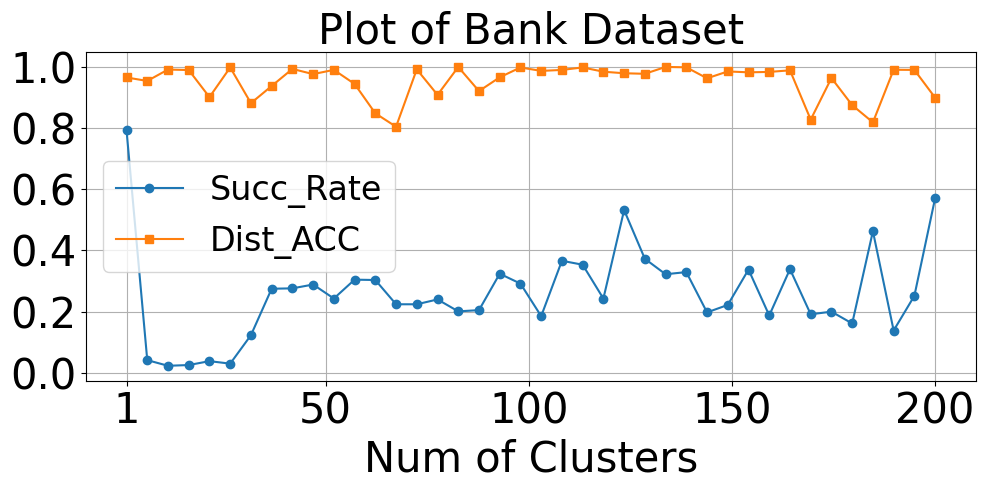

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
dataset = 'Bank'
# Example: these lists must already be defined
list1 = succ_rate_cluster
list2 = cluster_acc
# list2 = np.load('../RQs/Bank_cluster_acc_ges15.npy')
# list1 = np.load('../RQs/Bank_succ_rate_cluster_ges15.npy')

n = len(list1)

# Spread 40 points between x = 1 to 200
x = np.linspace(1, 200, n)

plt.figure(figsize=(10, 5))

plt.plot(x, list1, label='Succ_Rate', marker='o')
plt.plot(x, list2, label='Dist_ACC', marker='s')

plt.xlabel('Num of Clusters', fontsize=30)
plt.title('Plot of ' + dataset + ' Dataset', fontsize=30)

plt.xticks([1, 50, 100, 150, 200], fontsize=30)
plt.yticks(fontsize=30)

plt.legend(fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.savefig(dataset + "_cluster_analysis.png", dpi=600)
plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Example: these lists must already be defined
# list1 = succ_rate_cluster
# list2 = cluster_acc

n = len(list1)

# Spread 40 points between x = 1 to 200
x = np.linspace(1, 200, n)

plt.figure(figsize=(10, 5))
plt.plot(x, list1, label='Succ_Rate', marker='o')
plt.plot(x, list2, label='Dist_ACC', marker='s')

plt.xlabel('Num of Clusters')
plt.ylabel('Metric Value')
plt.title('Plot of ' + dataset + ' (X-Axis: 1 to 200)')

# Force x-axis to show only integer ticks
plt.xticks(np.arange(1, 201, 10))  # every 10 integers, adjust step as needed

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(dataset + "_cluster_analysis.png", dpi=600)
plt.show()

40

In [31]:
len(succ_rate_cluster),len(cluster_acc)

(320, 40)

In [20]:
glob.glob('../'+dataset+'_Analysis/'+algorithm_list[0]+'/PP/*.csv')

['../Law_Analysis/simy/PP\\Law_simy_pp_1.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_11.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_15.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_16.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_17.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_18.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_2.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_22.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_25.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_27.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_29.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_3.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_30.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_31.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_32.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_4.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_6.csv',
 '../Law_Analysis/simy/PP\\Law_simy_pp_8.csv']